<a href="https://colab.research.google.com/github/erlonL/series-temporais/blob/main/ST_Projeto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [295]:
!pip install yfinance snscrape pandas_market_calendars pandas_datareader snscrape transformers torch nltk tqdm IPython jupyter ipywidgets tensorflow tf-keras seaborn

In [296]:
import yfinance as yf
#import snscrape.modules.twitter as sntwitter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_market_calendars as mcal
import pandas_datareader.data as web
import pickle
import snscrape
from transformers import pipeline

In [297]:
new_model = pipeline(
    model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
    return_all_scores=True
)

/home/erlo/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/erlo/.local/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## ETAPA 1: Coleta e Tratamento de Dados

S&P 500, abreviação de Standard & Poor's 500, ou simplesmente S&P, trata-se de um índice composto por quinhentos ativos cotados nas bolsas de NYSE ou NASDAQ, qualificados devido ao seu tamanho de mercado, sua liquidez e sua representação de grupo industrial.

### Dados do mercado de ações

In [298]:
# ticker S&P 500
ticker = '^GSPC'
index = yf.Ticker(ticker)

# de acordo com nossa escolha
start_date = '2020-01-01'
end_date = '2024-09-25'

data = index.history(start=start_date, end=end_date)

# deixar apenas a data (y/m/d) na coluna date
data.index = data.index.date

# Exiba os primeiros registros para verificação
print(data.head())

                   Open         High          Low        Close      Volume  \
2020-01-02  3244.669922  3258.139893  3235.530029  3257.850098  3459930000   
2020-01-03  3226.360107  3246.149902  3222.340088  3234.850098  3484700000   
2020-01-06  3217.550049  3246.840088  3214.639893  3246.280029  3702460000   
2020-01-07  3241.860107  3244.909912  3232.429932  3237.179932  3435910000   
2020-01-08  3238.590088  3267.070068  3236.669922  3253.050049  3726840000   

            Dividends  Stock Splits  
2020-01-02        0.0           0.0  
2020-01-03        0.0           0.0  
2020-01-06        0.0           0.0  
2020-01-07        0.0           0.0  
2020-01-08        0.0           0.0  


No artigo, foi filtrado os dados para os dias úteis do mercado. Faremos a seguir esse processamento:

In [299]:
# filtrando os dados de stock para os dias uteis
nyse = mcal.get_calendar('NYSE')

dias_uteis = nyse.valid_days(start_date=start_date, end_date=end_date)

# Pegar so a data
dias_uteis = [dia.date() for dia in dias_uteis]

In [300]:
sp500 = data.loc[data.index.intersection(dias_uteis)]

print(sp500.head())

save = False
if save:
    sp500.to_csv("data/csv/sp500.csv")

                   Open         High          Low        Close      Volume  \
2020-01-02  3244.669922  3258.139893  3235.530029  3257.850098  3459930000   
2020-01-03  3226.360107  3246.149902  3222.340088  3234.850098  3484700000   
2020-01-06  3217.550049  3246.840088  3214.639893  3246.280029  3702460000   
2020-01-07  3241.860107  3244.909912  3232.429932  3237.179932  3435910000   
2020-01-08  3238.590088  3267.070068  3236.669922  3253.050049  3726840000   

            Dividends  Stock Splits  
2020-01-02        0.0           0.0  
2020-01-03        0.0           0.0  
2020-01-06        0.0           0.0  
2020-01-07        0.0           0.0  
2020-01-08        0.0           0.0  


In [301]:
sp500.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1190.000000,1190.000000,1190.000000,1190.000000,1.190000e+03,1190.0,1190.0
mean,4165.217473,4190.424592,4138.559578,4166.022263,4.403520e+09,0.0,0.0
std,677.736933,675.675810,680.305417,677.989815,1.049796e+09,0.0,0.0
min,2290.709961,2300.729980,2191.860107,2237.399902,1.639500e+09,0.0,0.0
25%,3786.674988,3819.482483,3749.492493,3790.517395,3.762062e+09,0.0,0.0
50%,4170.040039,4193.760010,4142.614990,4170.560059,4.130170e+09,0.0,0.0
75%,4531.830200,4545.984863,4509.594971,4527.872559,4.748670e+09,0.0,0.0
max,5727.660156,5735.319824,5704.220215,5732.930176,9.976520e+09,0.0,0.0


### Dados de Notícias / Redes Sociais

In [302]:
import pickle

# news articles
with open('data/pkl/df_news.pkl', 'rb') as f:
    news = pickle.load(f)
# bsky tweets
with open('data/pkl/df_socials.pkl', 'rb') as f:
    bsky = pickle.load(f)

In [303]:
news.head(2)

,title,text,label,links,symbol,company,date
0,Stocks making the biggest moves midday: Palo A...,A view of the exterior of the new Dutch head o...,-2,https://www.cnbc.com/2023/06/05/stocks-making-...,MMM,3M,2023-06-05
1,3M will spin off its health-care business into...,3M announced Tuesday it will spin off its heal...,-2,https://www.cnbc.com/2022/07/26/3m-will-spin-o...,MMM,3M,2022-07-26


In [304]:
bsky.head(2)

,name,user,date,text
0,Roberto Marsicano,@cannedcat.bsky.social,2024-09-21,a top-1% fund manager warns warren buffett is ...
1,copgamer,@copigamer.bsky.social,2024-09-21,microstrategy outperformed the s&p 500 with it...


# Etapa 2: Análise e Agregação de Sentimento através do DistilRoBERTa

In [305]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import RobertaTokenizer, TFRobertaModel
from tqdm import tqdm
# import clear_output()
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('portuguese'))

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = TFRobertaModel.from_pretrained("roberta-base")

def remove_stopwords(text):
    words = text.split()
    return " ".join([word for word in words if word.lower() not in stop_words])

def tokenize(text):
    tokenizer(text, truncation=True, max_length=500, return_tensors='tf')

clear_output()

In [306]:
tqdm.pandas()

# check if data/pkl/df_socials_sentiment.pkl exists
try:
    with open('data/pkl/df_socials_sentiment.pkl', 'rb') as f:
        bsky = pickle.load(f)
except:     
    tokens = []
    for index, row in bsky.iterrows():
        tokens.append(tokenizer(row['text'], truncation=True, max_length=500, return_tensors='tf'))

    decoded = []
    for token in tokens:
        decoded.append(tokenizer.decode(token['input_ids'][0]))

    bsky['decoded'] = decoded
    bsky['decoded'] = bsky['decoded'].apply(remove_stopwords)

    bsky.loc[:, 'short_text'] = bsky['decoded']
    bsky.loc[:, 'sentiment'] = bsky['short_text'].progress_apply(lambda x: new_model(x))

    bsky.head()

    save = True
    if save:
        with open('data/pkl/df_socials_sentiment.pkl', 'wb') as f:
                pickle.dump(bsky, f)

In [307]:
tqdm.pandas()

# check if data/pkl/df_news_sentiment.pkl exists
try:
    with open('data/pkl/df_news_sentiment.pkl', 'rb') as f:
        news = pickle.load(f)
except:
    tokens = []
    for index, row in news.iterrows():
        tokens.append(tokenizer(row['text'], truncation=True, max_length=500, return_tensors='tf'))

    decoded = []
    for token in tokens:
        decoded.append(tokenizer.decode(token['input_ids'][0]))

    news['decoded'] = decoded
    news['decoded'] = news['decoded'].apply(remove_stopwords)

    news.loc[:, 'short_text'] = news['decoded']
    news.loc[:, 'sentiment'] = news['short_text'].progress_apply(lambda x: new_model(x))

    news.head()

    save = True

    if save:
        with open('data/pkl/df_news_sentiment.pkl', 'wb') as f:
                pickle.dump(news, f)

Tratando os Dataframes  
- Remoção das colunas 'decoded', 'links', 'decoded', 'symbol' e 'company'  
- Tratamento da coluna 'sentiment'

In [308]:
print(news.columns)
print(bsky.columns)

Index(['title', 'text', 'label', 'links', 'symbol', 'company', 'date',
       'decoded', 'short_text', 'sentiment'],
      dtype='object')
Index(['name', 'user', 'date', 'text', 'decoded', 'short_text', 'sentiment'], dtype='object')


In [309]:
news = news.drop(columns=['decoded', 'links', 'symbol', 'company'])
bsky = bsky.drop(columns=['decoded', 'name'])

print(news.columns)
print(bsky.columns)

Index(['title', 'text', 'label', 'date', 'short_text', 'sentiment'], dtype='object')
Index(['user', 'date', 'text', 'short_text', 'sentiment'], dtype='object')


In [310]:
bsky.head()

,user,date,text,short_text,sentiment
0,@cannedcat.bsky.social,2024-09-21,a top-1% fund manager warns warren buffett is ...,<s>a top-1% fund manager warns warren buffett ...,"[[{'label': 'negative', 'score': 0.99809497594..."
1,@copigamer.bsky.social,2024-09-21,microstrategy outperformed the s&p 500 with it...,<s>microstrategy outperformed the s&p 500 with...,"[[{'label': 'negative', 'score': 0.00027101469..."
2,@aqsaa.bsky.social,2024-09-21,$mstr is beating 100% of the s&p 500 with,<s>$mstr is beating 100% of the s&p 500 with</s>,"[[{'label': 'negative', 'score': 0.00058746116..."
3,@sketchynews.net,2024-09-21,rate-cut euphoria is fading amid reminders of ...,<s>rate-cut euphoria is fading amid reminders ...,"[[{'label': 'negative', 'score': 0.99834644794..."
4,@basquiatball.bsky.social,2024-09-20,the computer that manages my s&p 500 eft poste...,<s>the computer that manages my s&p 500 eft po...,"[[{'label': 'negative', 'score': 0.99734038114..."


In [311]:
bsky['sentiment'].iloc[0]

[[{'label': 'negative', 'score': 0.9980949759483337},
  {'label': 'neutral', 'score': 0.0004345719935372472},
  {'label': 'positive', 'score': 0.001470473944209516}]]

In [312]:
bsky['negative_score'] = bsky['sentiment'].apply(lambda x: x[0][0]['score'])
bsky['neutral_score'] = bsky['sentiment'].apply(lambda x: x[0][1]['score'])
bsky['positive_score'] = bsky['sentiment'].apply(lambda x: x[0][2]['score'])

bsky = bsky.drop(columns=['sentiment'])

bsky.head(1)

,user,date,text,short_text,negative_score,neutral_score,positive_score
0,@cannedcat.bsky.social,2024-09-21,a top-1% fund manager warns warren buffett is ...,<s>a top-1% fund manager warns warren buffett ...,0.998095,0.000435,0.00147


In [313]:
news['negative_score'] = news['sentiment'].apply(lambda x: x[0][0]['score'])
news['neutral_score'] = news['sentiment'].apply(lambda x: x[0][1]['score'])
news['positive_score'] = news['sentiment'].apply(lambda x: x[0][2]['score'])

news = news.drop(columns=['sentiment'])

news.head(1)

,title,text,label,date,short_text,negative_score,neutral_score,positive_score
0,Stocks making the biggest moves midday: Palo A...,A view of the exterior of the new Dutch head o...,-2,2023-06-05,<s>A view of the exterior of the new Dutch hea...,0.162254,0.000359,0.837387


## Agregando a média dos sentimentos para cada dia

In [314]:
# série temporal de médias de sentimentos para cada dia
# agregar os scores 

bsky_values = bsky[['date', 'negative_score', 'neutral_score', 'positive_score']]
news_values = news[['date', 'negative_score', 'neutral_score', 'positive_score']]

In [315]:
ts_scores = pd.concat([bsky_values, news_values]).groupby('date').mean()
ts_scores.head()

,negative_score,neutral_score,positive_score
date,,,
2020-01-02,0.997598,0.001034,0.001368
2020-01-03,0.000223,0.000103,0.999674
2020-01-06,0.000436,0.000174,0.999390
2020-01-08,0.000252,0.000071,0.999677
2020-01-09,0.000100,0.999775,0.000125


In [316]:
# removendo os finais de semana (caso existam)
# filtrando os dados de stock para os dias uteis
nyse = mcal.get_calendar('NYSE')
dias_uteis = nyse.valid_days(start_date=ts_scores.index[0], end_date=ts_scores.index[-1])
# Pegar so a data
dias_uteis = [dia.date() for dia in dias_uteis]

# Converter os índices de ts_scores para datas
ts_scores.index = ts_scores.index.date

ts_scores_wd = ts_scores.loc[ts_scores.index.intersection(dias_uteis)]

#clear_output() # não existem erros se não podemos vê-los

ts_scores_wd.head()

,negative_score,neutral_score,positive_score
2020-01-02,0.997598,0.001034,0.001368
2020-01-03,0.000223,0.000103,0.999674
2020-01-06,0.000436,0.000174,0.999390
2020-01-08,0.000252,0.000071,0.999677
2020-01-09,0.000100,0.999775,0.000125


In [317]:
sp500_values = sp500[['Close']]

df = ts_scores_wd.join(sp500_values)
df.head()

,negative_score,neutral_score,positive_score,Close
2020-01-02,0.997598,0.001034,0.001368,3257.850098
2020-01-03,0.000223,0.000103,0.999674,3234.850098
2020-01-06,0.000436,0.000174,0.999390,3246.280029
2020-01-08,0.000252,0.000071,0.999677,3253.050049
2020-01-09,0.000100,0.999775,0.000125,3274.699951


# Treinando a Rede

sem análise de sentimentos

In [411]:
ts = df[['Close']]

train = ts[:int(0.7*(len(ts)))]
test = ts[int(0.7*(len(ts))):]

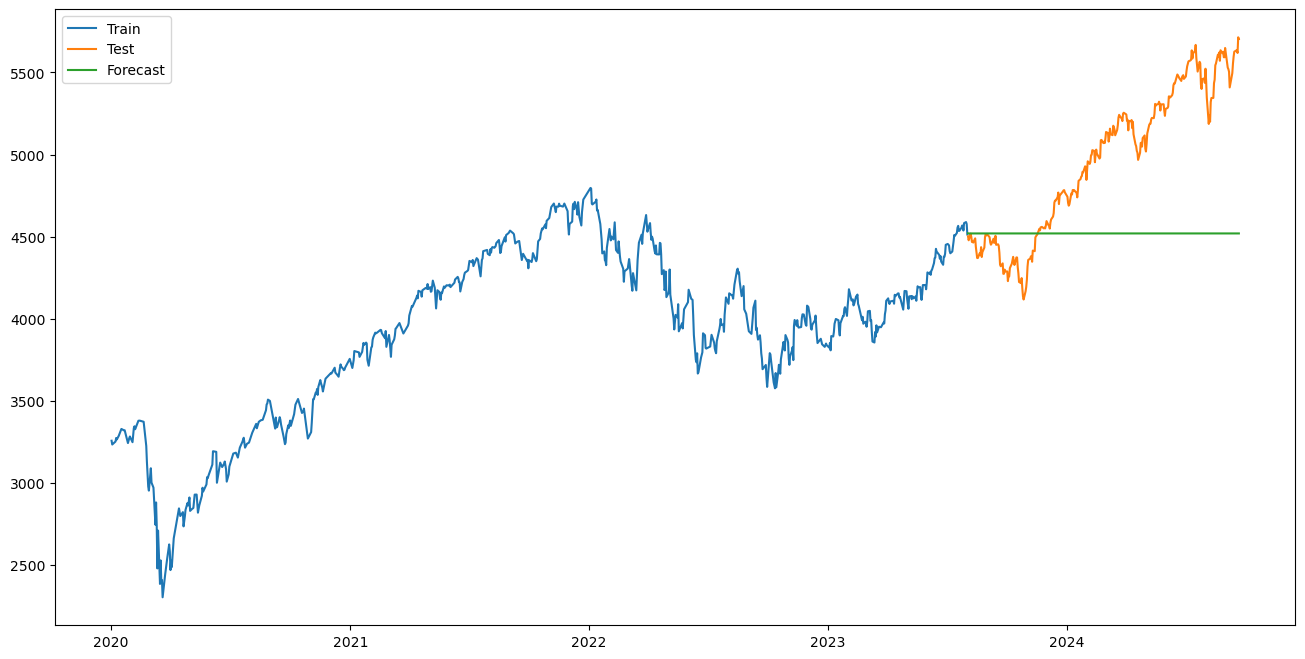

In [412]:
# sem análise de sentimentos, utilizando AUTOARIMA
from pmdarima import auto_arima

# fit the model
model = auto_arima(train, error_action='ignore', suppress_warnings=True)

model.fit(train)

# predict the future
forecast = model.predict(n_periods=len(test))
clear_output()
# plot forecast
plt.figure(figsize=(16,8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.show()

In [414]:
# métrica de erro (mae)
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test, forecast)
print(f'MAE: {mae}')

MAE: 514.5722632522899


/home/erlo/.local/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/erlo/.local/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


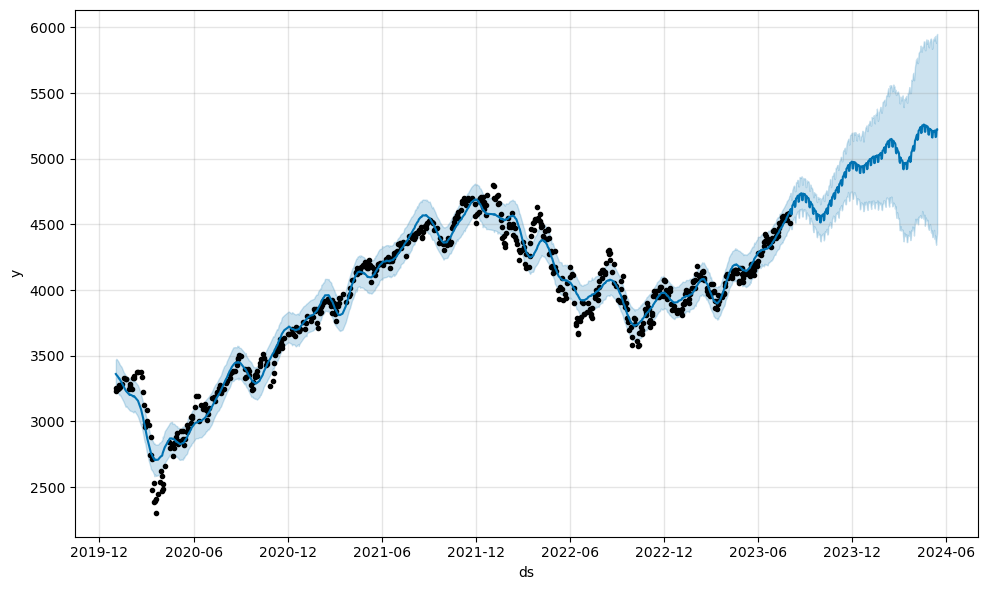

In [416]:
# usando prophet
from prophet import Prophet

m = Prophet()
train.loc[:, 'ds'] = train.index
train.loc[:, 'y'] = train['Close']

m.fit(train)

future = m.make_future_dataframe(periods=len(test))

forecast = m.predict(future)
clear_output()
m.plot(forecast)
plt.show()

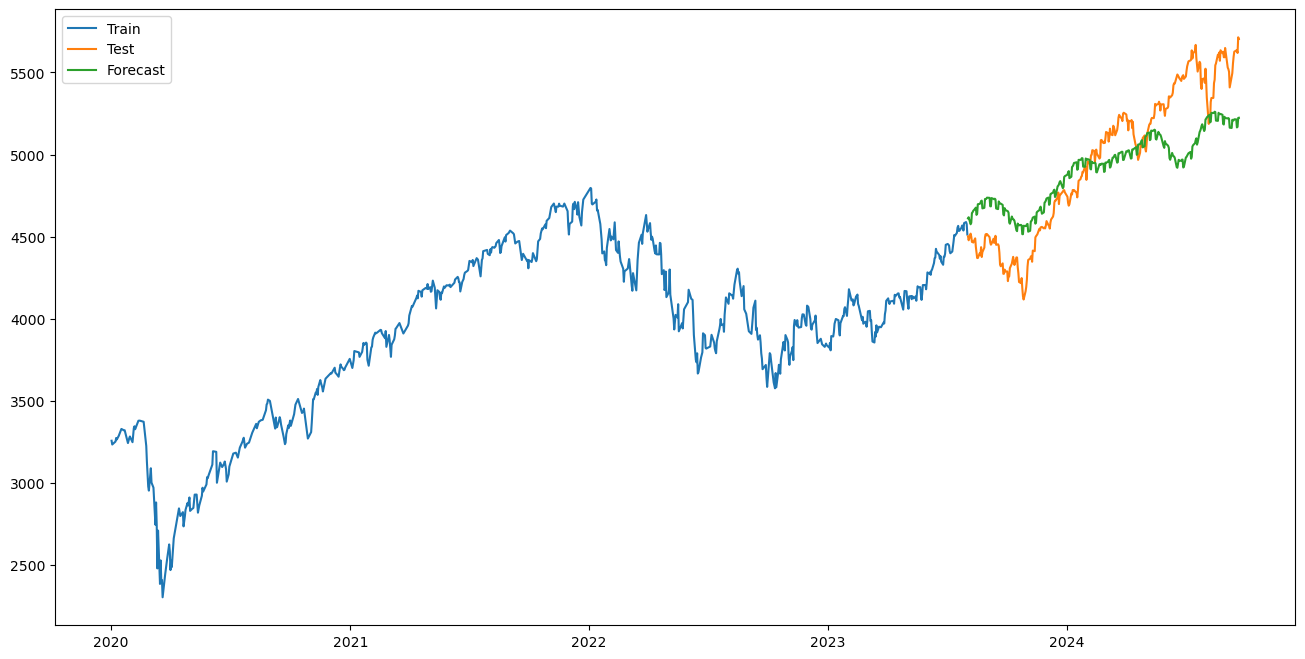

In [417]:
# plot forecast
plt.figure(figsize=(16,8))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')

plt.plot(test.index, forecast['yhat'][len(train):], label='Forecast')
plt.legend()
plt.show()

/home/erlo/.local/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/erlo/.local/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/erlo/.local/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavi

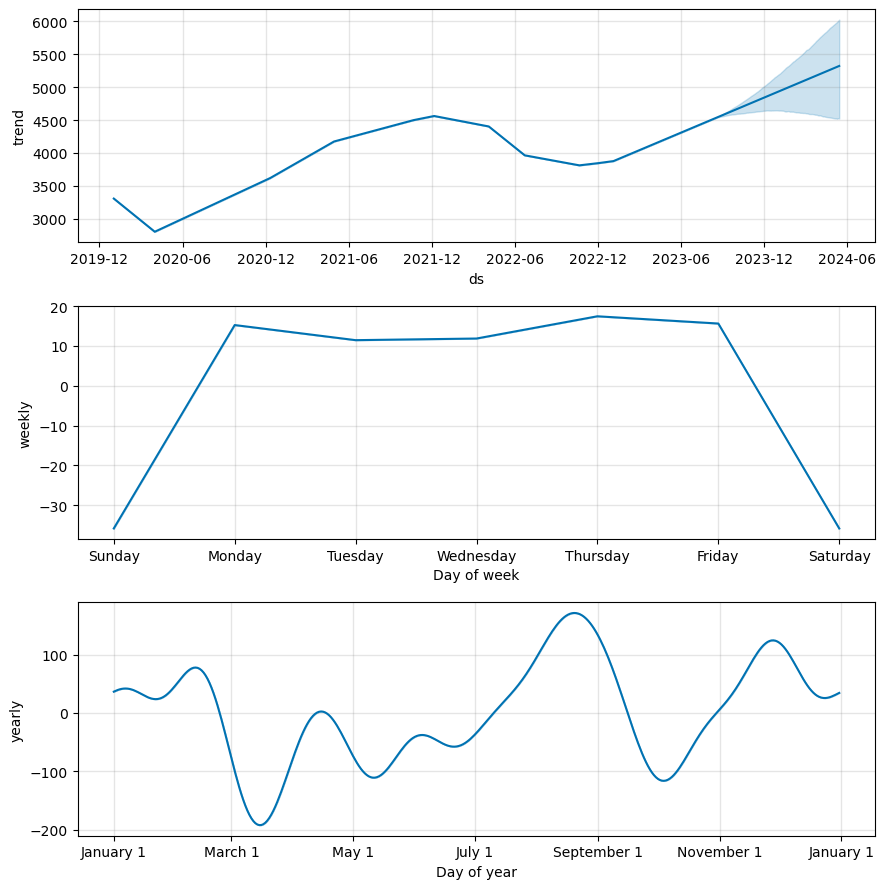

In [418]:
m.plot_components(forecast)
plt.show()

In [419]:
# métricas de erro (MAE)
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test['Close'], forecast['yhat'][len(train):])
print(f'MAE: {mae}')

MAE: 228.57070320624544


com análise de sentimentos

Sequencial

In [479]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

# normalizando os dados de Close
from sklearn.preprocessing import MaxAbsScaler, RobustScaler

from tensorflow.keras.callbacks import EarlyStopping

In [480]:
X = df[['negative_score', 'neutral_score', 'positive_score']]
y = df[['Close']]

scaler = MaxAbsScaler()
y_scaled = scaler.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2)

In [481]:
len(X_train), len(X_val), len(X_test)

(608, 153, 191)

In [486]:
model = Sequential()

model.add(Dense(6, activation='tanh', input_dim=3, kernel_initializer='normal'))
#model.add(Dropout(0.1))

model.add(Dense(3, activation='relu', kernel_initializer='normal'))
#model.add(Dropout(0.1))

model.add(Dense(1))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)

model.compile(optimizer='adam', loss='mae')

print(model.summary())

/home/erlo/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_189 (Dense)               │ (None, 6)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49 (196.00 B)

 Trainable params: 49 (196.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [487]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=16, callbacks=[es])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7243 - val_loss: 0.6512
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6245 - val_loss: 0.5082
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4575 - val_loss: 0.2732
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2071 - val_loss: 0.0963
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 0.0972 - val_loss: 0.0948
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 0.0928 - val_loss: 0.0930
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0899 - val_loss: 0.0932
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 0.0863 - val_loss: 0.0923
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0840 - val_loss: 0.0926
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0857 - val_loss: 0.0919
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 0.0908 - val_loss: 0.0932
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step

<AxesSubplot: >

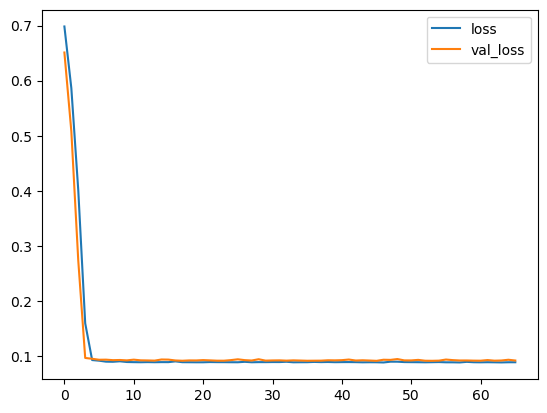

In [488]:
# avaliando o modelo
losses = pd.DataFrame(model.history.history)
losses.plot()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MAE: 430.9478331560864


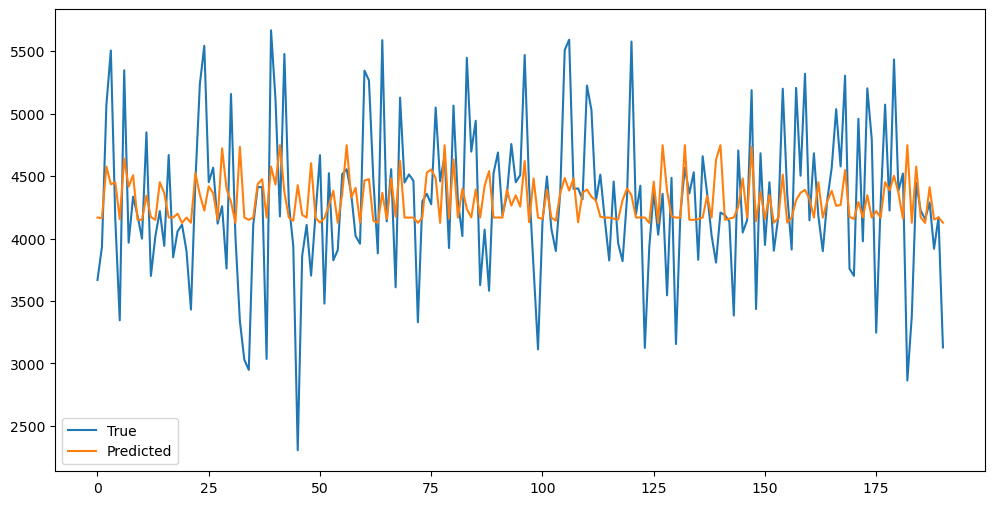

In [489]:
y_pred = model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f'MAE: {mae}')

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='True')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.show()

Prophet

In [474]:
X = df.copy()
X.loc[:, 'ds'] = X.index
X.rename(columns={'Close': 'y'}, inplace=True)
X.dropna(inplace=True, subset=['negative_score'])

X_train = X[:int(0.7*(len(X)))]
X_test = X[int(0.7*(len(X))):]

m = Prophet()
m.add_regressor('negative_score')
m.add_regressor('neutral_score')
m.add_regressor('positive_score')
m.fit(X_train)

09:52:52 - cmdstanpy - INFO - Chain [1] start processing
09:52:52 - cmdstanpy - INFO - Chain [1] done processing


In [475]:
future = m.make_future_dataframe(periods=len(X_test))
future.loc[:, 'negative_score'] = X_train['negative_score']
future.loc[:, 'neutral_score'] = X_train['neutral_score']
future.loc[:, 'positive_score'] = X_train['positive_score']

future.fillna({'negative_score': X_train['negative_score'].mean(), 'neutral_score': X_train['neutral_score'].mean(), 'positive_score': X_train['positive_score'].mean()}, inplace=True)

/home/erlo/.local/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/erlo/.local/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


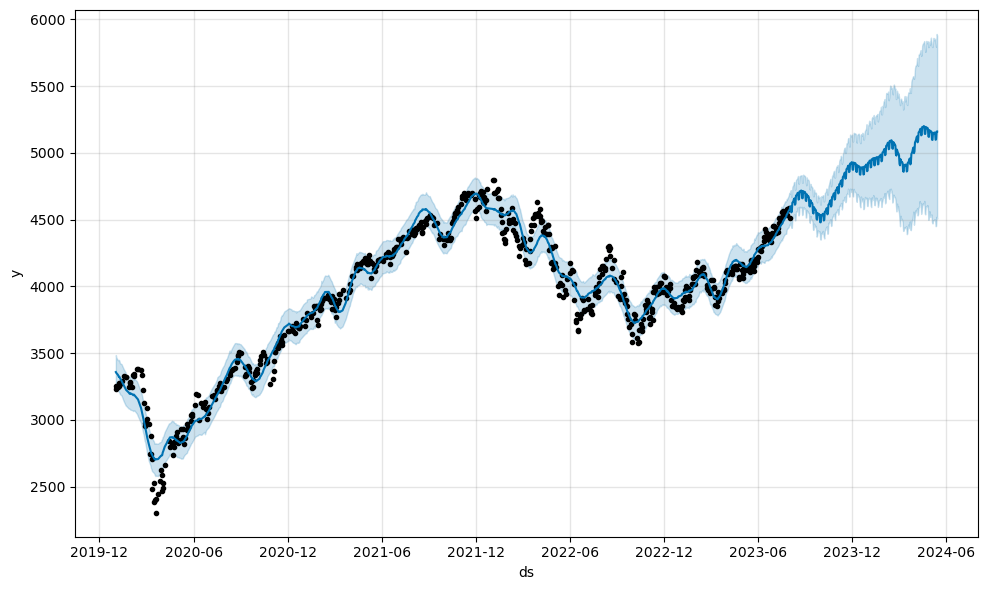

In [476]:
forecast = m.predict(future)

m.plot(forecast)
plt.show()

MAE: 244.38479407750333


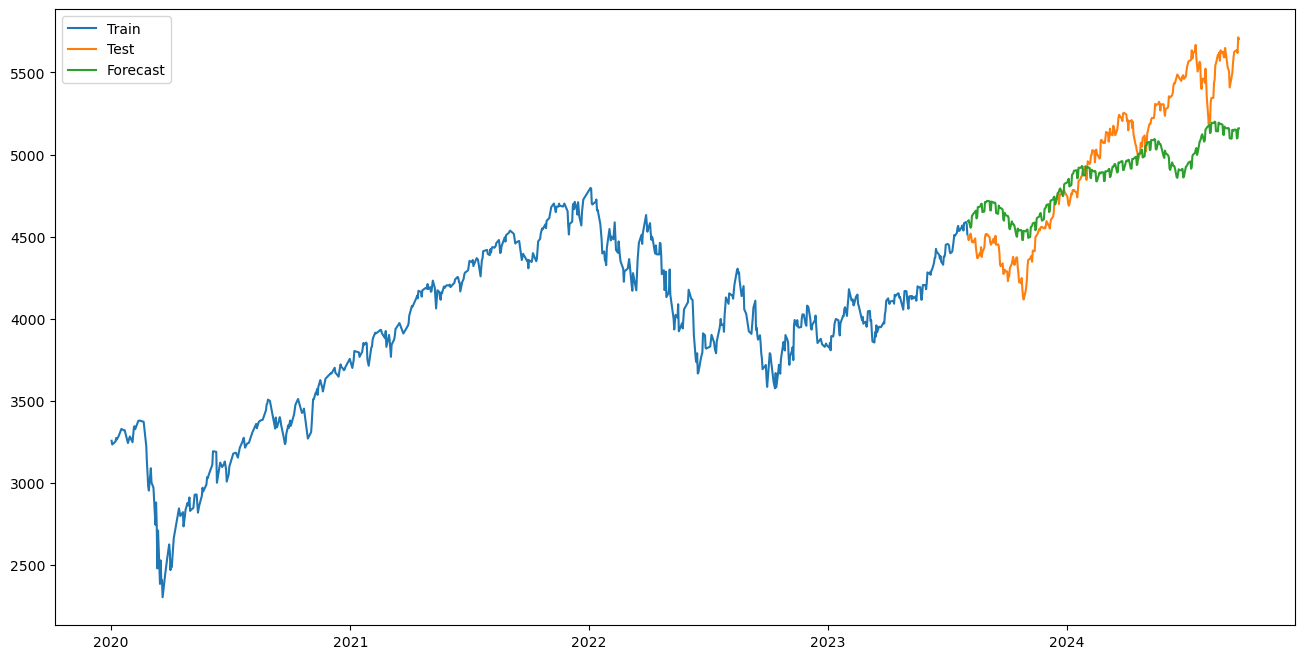

In [478]:
# error metric (MAE)
mae = mean_absolute_error(X_test['y'], forecast['yhat'][len(X_train):])
print(f'MAE: {mae}')

# plot forecast with test data
plt.figure(figsize=(16,8))
plt.plot(X_train['ds'], X_train['y'], label='Train')
plt.plot(X_test['ds'], X_test['y'], label='Test')
plt.plot(X_test['ds'], forecast['yhat'][len(X_train):], label='Forecast')
plt.legend()
plt.show()